In [ ]:
from __future__ import absolute_import, division, print_function

import tensorflow as tf

import tensorflow.keras.backend as K
from tensorflow.keras.models import load_model
from tensorflow.keras.preprocessing import image
from tensorflow.keras import regularizers
from tensorflow.keras.applications.inception_v3 import InceptionV3
from tensorflow.keras.models import Model
from tensorflow.keras.layers import Dense, Dropout
from tensorflow.keras.layers import GlobalAveragePooling2D
from tensorflow.keras.preprocessing.image import ImageDataGenerator
from tensorflow.keras.callbacks import ModelCheckpoint, CSVLogger
from tensorflow.keras.optimizers import SGD
from tensorflow.keras.regularizers import l2

from tensorflow import keras
from tensorflow.keras import models
from tensorflow.keras.applications.inception_v3 import preprocess_input

import cv2
import os
import random
import collections
from collections import defaultdict

from shutil import copy
from shutil import copytree, rmtree

import numpy as np

import matplotlib.pyplot as plt
import matplotlib.image as img
%matplotlib inline


In [ ]:
# Check TF version and whether GPU is enabled
print(tf.__version__)
print(tf.test.gpu_device_name())

2.6.0
/device:GPU:0


In [ ]:
# Clone tensorflow/examples repo which has images to evaluate trained model
!git clone https://github.com/tensorflow/examples.git

Cloning into 'examples'...
remote: Enumerating objects: 19288, done.
remote: Counting objects: 100% (1108/1108), done.
remote: Compressing objects: 100% (616/616), done.
remote: Total 19288 (delta 467), reused 907 (delta 290), pack-reused 18180
Receiving objects: 100% (19288/19288), 30.59 MiB | 8.71 MiB/s, done.
Resolving deltas: 100% (10561/10561), done.


In [ ]:
from google.colab import drive
drive.mount('/content/drive',force_remount=True)

Mounted at /content/drive


In [ ]:
import os
#os.chdir("/content/drive/MyDrive")

In [ ]:

!unrar x "/content/drive/MyDrive/food20dataset.rar" "food20dataset"

Streaming output truncated to the last 5000 lines.
Extracting  food20dataset/train_set/strawberry_shortcake/3768962.jpg      94%  OK 
Extracting  food20dataset/train_set/strawberry_shortcake/3768985.jpg      94%  OK 
Extracting  food20dataset/train_set/strawberry_shortcake/3774533.jpg      94%  OK 
Extracting  food20dataset/train_set/strawberry_shortcake/3775808.jpg      94%  OK 
Extracting  food20dataset/train_set/strawberry_shortcake/3778399.jpg      94%  OK 
Extracting  food20dataset/train_set/strawberry_shortcake/3779221.jpg      94%  OK 
Extracting  food20dataset/train_set/strawberry_shortcake/3789427.jpg      94%  OK 
Extracting  food20dataset/train_set/strawberry_shortcake/3798069.jpg      94%  OK 
Extracting  food20dataset/train_set/strawberry_shortcake/3798148.jpg      94%  OK 
Extracting  food20dataset/train_set/strawberry_shortcake/3799875.jpg      94%  OK 
Extracting  food20dataset/tra

In [ ]:
print("Total number of samples in train folder")
train_files = sum([len(files) for i, j, files in os.walk("food20dataset/train_set")])
print(train_files)

Total number of samples in train folder
77150


In [ ]:
print("Total number of samples in test folder")
test_files = sum([len(files) for i, j, files in os.walk("food20dataset/test_set")])
print(test_files)

Total number of samples in test folder
25850


In [ ]:
# Helper method to create train_mini and test_mini data samples
def dataset_mini(food_list, src, dest):
  if os.path.exists(dest):
    rmtree(dest) # removing dataset_mini(if it already exists) folders so that we will have only the classes that we want
  os.makedirs(dest)
  for food_item in food_list :
    print("Copying images into",food_item)
    copytree(os.path.join(src,food_item), os.path.join(dest,food_item))

In [ ]:
# picking 3 food items and generating separate data folders for the same
food_list = ['biriyani','chappati','french_fries','ice_cream','idly','noodles','omelette','pizza','samosa','sushi']
src_train = 'food20dataset/train_set'
dest_train = 'food20dataset/train_mini'
src_test = 'food20dataset/test_set'
dest_test = 'food20dataset/test_mini'

In [ ]:
print("Creating train data folder with new classes")
dataset_mini(food_list, src_train, dest_train)

Creating train data folder with new classes
Copying images into biriyani
Copying images into chappati
Copying images into french_fries
Copying images into ice_cream
Copying images into idly
Copying images into noodles
Copying images into omelette
Copying images into pizza
Copying images into samosa
Copying images into sushi


In [ ]:
print("Total number of samples in train folder")
train_files = sum([len(files) for i, j, files in os.walk("food20dataset/train_mini")])
print(train_files)

Total number of samples in train folder
4850


In [ ]:
print("Creating test data folder with new classes")
dataset_mini(food_list, src_test, dest_test)

Creating test data folder with new classes
Copying images into biriyani
Copying images into chappati
Copying images into french_fries
Copying images into ice_cream
Copying images into idly
Copying images into noodles
Copying images into omelette
Copying images into pizza
Copying images into samosa
Copying images into sushi


In [ ]:
print("Total number of samples in test folder")
test_files = sum([len(files) for i, j, files in os.walk("food20dataset/test_mini")])
print(test_files)

Total number of samples in test folder
1650


In [ ]:
def train_model(n_classes,num_epochs, nb_train_samples,nb_validation_samples):
  K.clear_session()

  img_width, img_height = 299, 299
  train_data_dir = 'food20dataset/train_mini'
  validation_data_dir = 'food20dataset/test_mini'
  batch_size = 30
  bestmodel_path = 'bestmodel_'+str(n_classes)+'class.hdf5'
  trainedmodel_path = 'trainedmodel_'+str(n_classes)+'class.hdf5'
  history_path = 'history_'+str(n_classes)+'.log'

  train_datagen = ImageDataGenerator(
      preprocessing_function=preprocess_input,
      shear_range=0.2,
      zoom_range=0.2,
      horizontal_flip=True)

  test_datagen = ImageDataGenerator(preprocessing_function=preprocess_input)

  train_generator = train_datagen.flow_from_directory(
      train_data_dir,
      target_size=(img_height, img_width),
      batch_size=batch_size,
      class_mode='categorical')

  validation_generator = test_datagen.flow_from_directory(
      validation_data_dir,
      target_size=(img_height, img_width),
      batch_size=batch_size,
      class_mode='categorical')


  inception = InceptionV3(weights='imagenet', include_top=False)
  x = inception.output
  x = GlobalAveragePooling2D()(x)
  x = Dense(128,activation='relu')(x)
  x = Dropout(0.2)(x)

  predictions = Dense(n_classes,kernel_regularizer=regularizers.l2(0.005), activation='softmax')(x)

  model = Model(inputs=inception.input, outputs=predictions)
  model.compile(optimizer=SGD(lr=0.0001, momentum=0.9), loss='categorical_crossentropy', metrics=['accuracy'])
  checkpoint = ModelCheckpoint(filepath=bestmodel_path, verbose=1, save_best_only=True)
  csv_logger = CSVLogger(history_path)

  history = model.fit_generator(train_generator,
                      steps_per_epoch = nb_train_samples // batch_size,
                      validation_data=validation_generator,
                      validation_steps=nb_validation_samples // batch_size,
                      epochs=num_epochs,
                      verbose=1,
                      callbacks=[csv_logger, checkpoint])

  model.save(trainedmodel_path)
  class_map = train_generator.class_indices
  return history, class_map

In [ ]:
# Train the model with data from 3 classes
n_classes = 10
epochs = 20
nb_train_samples = train_files
nb_validation_samples = test_files

history, class_map_3 = train_model(n_classes,epochs, nb_train_samples,nb_validation_samples)
print(class_map_3)

Found 4850 images belonging to 10 classes.
Found 1650 images belonging to 10 classes.
87924736/87910968 [==============================] - 1s 0us/step


/usr/local/lib/python3.7/dist-packages/keras/optimizer_v2/optimizer_v2.py:356: UserWarning: The `lr` argument is deprecated, use `learning_rate` instead.
  "The `lr` argument is deprecated, use `learning_rate` instead.")
/usr/local/lib/python3.7/dist-packages/keras/engine/training.py:1972: UserWarning: `Model.fit_generator` is deprecated and will be removed in a future version. Please use `Model.fit`, which supports generators.
  warnings.warn('`Model.fit_generator` is deprecated and '


Epoch 1/20
161/161 [==============================] - 251s 1s/step - loss: 2.1784 - accuracy: 0.2654 - val_loss: 1.7807 - val_accuracy: 0.5715

Epoch 00001: val_loss improved from inf to 1.78073, saving model to bestmodel_10class.hdf5
Epoch 2/20
161/161 [==============================] - 199s 1s/step - loss: 1.6676 - accuracy: 0.5388 - val_loss: 1.3605 - val_accuracy: 0.7327

Epoch 00002: val_loss improved from 1.78073 to 1.36049, saving model to bestmodel_10class.hdf5
Epoch 3/20
161/161 [==============================] - 199s 1s/step - loss: 1.3204 - accuracy: 0.6620 - val_loss: 1.0497 - val_accuracy: 0.7800

Epoch 00003: val_loss improved from 1.36049 to 1.04967, saving model to bestmodel_10class.hdf5
Epoch 4/20
161/161 [==============================] - 199s 1s/step - loss: 1.0695 - accuracy: 0.7324 - val_loss: 0.8376 - val_accuracy: 0.8182

Epoch 00004: val_loss improved from 1.04967 to 0.83756, saving model to bestmodel_10class.hdf5
Epoch 5/20
161/161 [============================

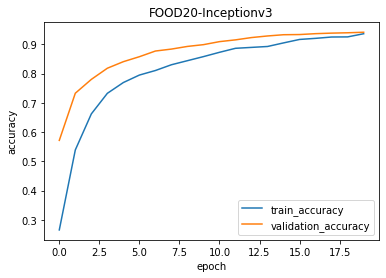

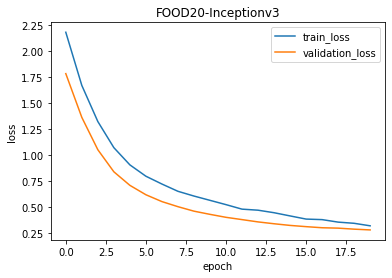

In [ ]:
# Visualize the accuracy and loss plots
def plot_accuracy(history,title):
    plt.title(title)
    plt.plot(history.history['accuracy']) # change acc to accuracy if testing TF 2.0
    plt.plot(history.history['val_accuracy']) # change val_accuracy if testing TF 2.0
    plt.ylabel('accuracy')
    plt.xlabel('epoch')
    plt.legend(['train_accuracy', 'validation_accuracy'], loc='best')
    plt.show()


def plot_loss(history,title):
    plt.title(title)
    plt.plot(history.history['loss'])
    plt.plot(history.history['val_loss'])
    plt.ylabel('loss')
    plt.xlabel('epoch')
    plt.legend(['train_loss', 'validation_loss'], loc='best')
    plt.show()


plot_accuracy(history,'FOOD20-Inceptionv3')
plot_loss(history,'FOOD20-Inceptionv3')

In [ ]:
%%time
# Loading the best saved model to make predictions

K.clear_session()
model_best = load_model('/content/drive/MyDrive/bestmodel_10class.hdf5',compile = False)

CPU times: user 2.97 s, sys: 628 ms, total: 3.6 s
Wall time: 10.1 s


In [ ]:
model_best = load_model('/content/keras_model.h5',compile = False)

In [ ]:
##food_list = ['biriyani','pizza','ice_cream','idly','samosa']
def predict_class(model, images, show = True):
  for img in images:
    img = image.load_img(img, target_size=( 224, 224, 3))
    img = image.img_to_array(img)                    
    img = np.expand_dims(img, axis=0)         
    img = preprocess_input(img)                                      

    pred = model.predict(img)
    index = np.argmax(pred)
    pred_value = food_list[index]
    print(pred)
    if show:
        plt.imshow(img[0])                           
        plt.axis('off')
        plt.title(pred_value)
        plt.show()
    return pred_value

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


[[0.9023592  0.00129056 0.00177117 0.00171589 0.00489589 0.07693963
  0.00116579 0.00551245 0.00160654 0.00274294]]


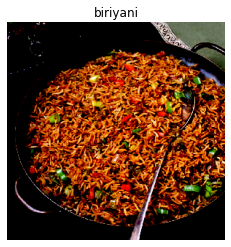

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


[[0.00692923 0.00299806 0.00378532 0.9004627  0.04998196 0.0077834
  0.00301583 0.00139526 0.00199772 0.02165053]]


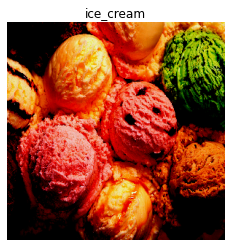

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


[[1.3548818e-04 1.3661106e-03 1.7569595e-04 9.1973669e-04 5.2777067e-04
  4.3789015e-04 2.4149001e-03 9.9307233e-01 5.6306971e-04 3.8704049e-04]]


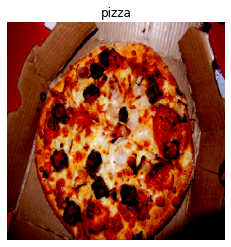

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


[[1.5576328e-04 6.1576522e-04 1.3010773e-04 2.8416759e-04 2.7872180e-04
  1.9179629e-04 4.8100678e-03 9.9170387e-01 1.4663087e-03 3.6354287e-04]]


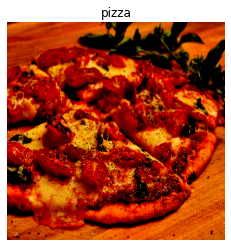

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


[[0.00443548 0.00485927 0.00156746 0.06068888 0.8989167  0.00122245
  0.00877288 0.00561098 0.00529251 0.00863335]]


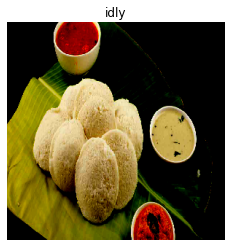

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


[[0.89903754 0.00255708 0.00176166 0.0017193  0.00465495 0.07875759
  0.00239703 0.0043382  0.00309937 0.00167727]]


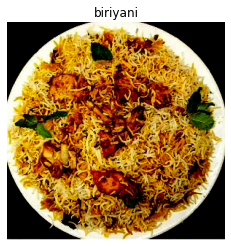

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


[[6.3727569e-04 4.1603381e-03 3.0049910e-03 8.9492726e-01 5.2819006e-02
  1.2329830e-03 1.3343734e-02 3.6489461e-03 2.4452340e-02 1.7731163e-03]]


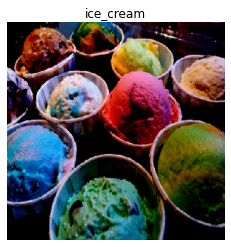

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


[[7.0935214e-04 5.5004759e-03 5.9090188e-04 2.9752761e-04 9.3211589e-04
  2.3401275e-03 9.2087179e-01 6.0477432e-02 7.7018803e-03 5.7840167e-04]]


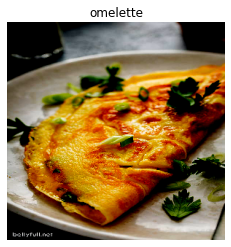

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


[[9.0535760e-01 6.2756374e-04 1.0572228e-03 6.6358610e-03 7.0240186e-03
  7.2430491e-02 7.7257614e-04 6.4054434e-04 1.2234391e-03 4.2306758e-03]]


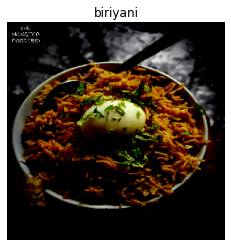

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


[[9.6719879e-01 4.0186153e-04 3.1709293e-04 1.3326528e-03 1.9429132e-03
  2.2715326e-02 1.3388309e-03 1.0701519e-03 1.0762211e-03 2.6061623e-03]]


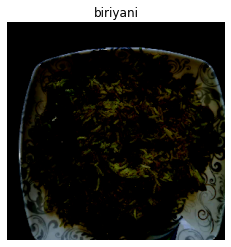

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


[[0.9265826  0.00107411 0.00165098 0.00581414 0.00317825 0.05038334
  0.00180402 0.00327001 0.00463472 0.00160793]]


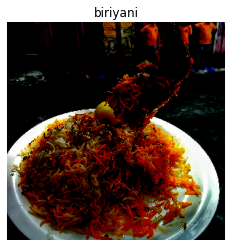

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


[[2.9403341e-04 4.2449462e-04 4.4016785e-04 9.8325747e-01 7.6043163e-03
  1.5037131e-04 4.3816464e-03 5.7291944e-04 8.4841944e-04 2.0262625e-03]]


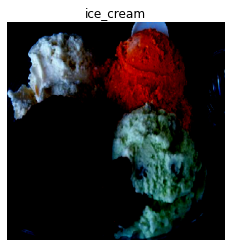

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


[[0.01880077 0.00397512 0.00738596 0.12363401 0.7996814  0.00790611
  0.01054143 0.00386614 0.00748851 0.01672043]]


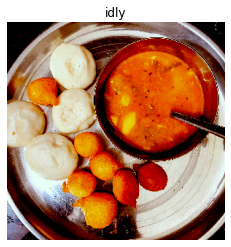

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


[[1.09131135e-04 3.34435725e-04 2.03437274e-04 1.56319700e-04
  2.82794004e-04 4.03501705e-04 7.58484937e-04 2.86688656e-03
  9.94782507e-01 1.02426573e-04]]


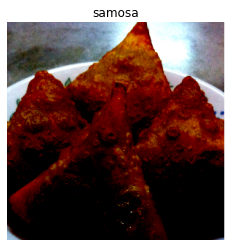

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


[[0.0321233  0.02565617 0.01695069 0.1137082  0.7014976  0.01527436
  0.03744484 0.01315511 0.02660003 0.01758981]]


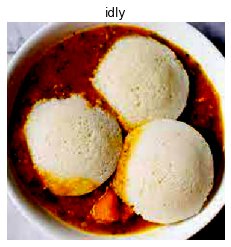

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


[[0.03194106 0.01450436 0.01344959 0.06436933 0.64672303 0.01775508
  0.01820971 0.00404164 0.01723048 0.17177577]]


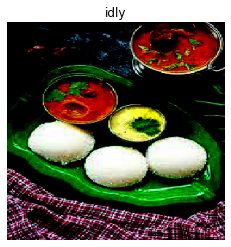

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


[[3.3233667e-04 7.5946598e-05 6.3911563e-04 5.2338652e-04 1.8939206e-04
  1.9369819e-04 1.0718055e-03 1.3757241e-04 2.6957062e-04 9.9656713e-01]]


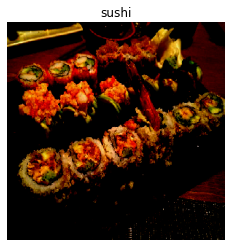

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


[[0.0022111  0.00135367 0.00898219 0.9529747  0.00321792 0.00318193
  0.00336594 0.0056804  0.00370738 0.01532486]]


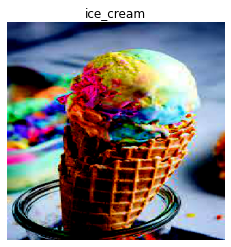

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


[[0.83519214 0.00393295 0.00473725 0.00244882 0.01164865 0.10823416
  0.00463561 0.00794499 0.01095329 0.01027217]]


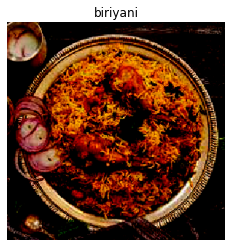

In [ ]:
# Make a list of downloaded images and test the trained model
images = []
images.append('1.jpg')
images.append('2.jpg')
images.append('3.jpg')
images.append('Pizza.jpg')
images.append('4.jpg')
images.append('5.jpg')
images.append('6.jpg')
images.append('Omelette.jpg')
images.append('7.jpg')
images.append('8.jpg')
images.append('9.jpg')

images.append('10.jpg')
images.append('11.jpg')
images.append('samosa.jpg')

images.append('12.jpg')
images.append('13.jpg')
images.append('14.jpg')
images.append('15.jpg')
images.append('16.jpg')
predict_class(model_best, images, True)

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


[[1.5352890e-04 2.8020167e-04 9.9831748e-01 1.7069060e-04 2.6352411e-05
  8.7205677e-05 5.8747607e-04 7.6925200e-05 7.5221527e-05 2.2486402e-04]]


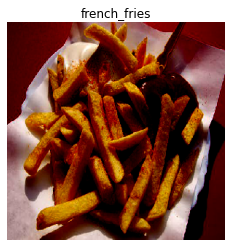

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


[[6.9340609e-04 1.2055809e-03 9.8716080e-01 5.8133663e-03 2.7550489e-04
  8.6470461e-04 2.2239541e-03 4.9137062e-04 4.0517724e-04 8.6621632e-04]]


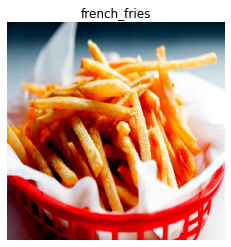

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


[[1.0207165e-03 9.3513513e-01 3.6513372e-03 2.7233649e-03 9.0392372e-03
  4.9155513e-03 3.1914268e-02 9.1743106e-03 1.4941541e-03 9.3207054e-04]]


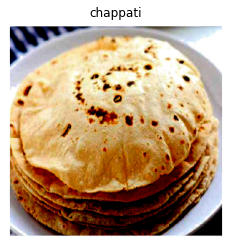

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


[[0.00267527 0.7817286  0.00270158 0.00098244 0.01594548 0.01167531
  0.12210059 0.00912157 0.05186728 0.00120177]]


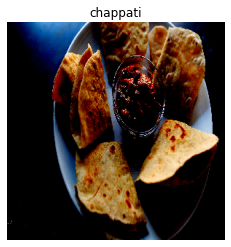

In [ ]:
images = []
images.append('17.jpeg')
images.append('18.jpg')
images.append('19.jpeg')
images.append('20.jpg')

predict_class(model_best, images, True)

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


[[1.5352890e-04 2.8020167e-04 9.9831748e-01 1.7069060e-04 2.6352411e-05
  8.7205677e-05 5.8747607e-04 7.6925200e-05 7.5221527e-05 2.2486402e-04]]


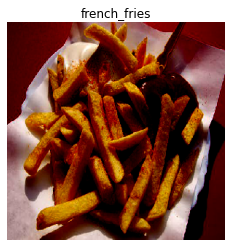

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


[[6.9340609e-04 1.2055809e-03 9.8716080e-01 5.8133663e-03 2.7550489e-04
  8.6470461e-04 2.2239541e-03 4.9137062e-04 4.0517724e-04 8.6621632e-04]]


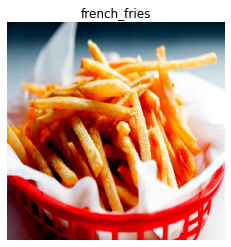

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


[[1.0207165e-03 9.3513513e-01 3.6513372e-03 2.7233649e-03 9.0392372e-03
  4.9155513e-03 3.1914268e-02 9.1743106e-03 1.4941541e-03 9.3207054e-04]]


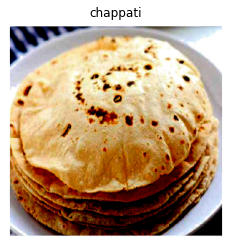

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


[[0.00267527 0.7817286  0.00270158 0.00098244 0.01594548 0.01167531
  0.12210059 0.00912157 0.05186728 0.00120177]]


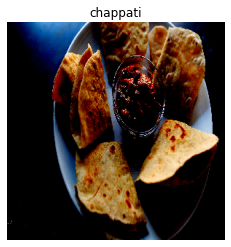

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


[[8.1806921e-04 1.1912046e-02 2.0204864e-03 5.9662393e-04 8.9682668e-04
  3.9678300e-03 9.5512015e-01 1.3314912e-02 8.4159533e-03 2.9372168e-03]]


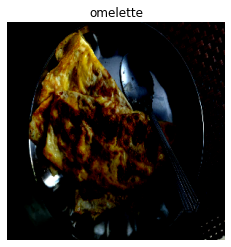

In [ ]:
images.append('21.jpg')
predict_class(model_best, images, True)

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


[[0.89903754 0.00255708 0.00176166 0.0017193  0.00465495 0.07875759
  0.00239703 0.0043382  0.00309937 0.00167727]]


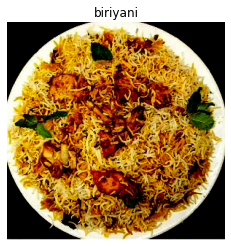

In [ ]:
images = []
images.append('5.jpg')

x=predict_class(model_best, images, True)


In [ ]:


import json
f = open('/content/Recipe_File.json', 'r')
data = json.load(f)


food = data[x]

listss = ["", 'ingredients', 'instructions', 'title']

options = int(input('''
1.Ingredient
2.Instructions
3.Title
'''))

if(options == 1):
    print('The Ingredients are :')
    for i in food[listss[options]]:
        print(i)
else:
    print(food[listss[options]])

y = food['instructions']
f.close()


1.Ingredient
2.Instructions
3.Title
1
The Ingredients are :
2 1/2 tablespoons olive oil  
3 tablespoons plain yogurt  
2 tablespoons distilled white vinegar  
1 medium onion, sliced  
2 cloves garlic, crushed  
1 tablespoon ginger paste  
2 small green chile peppers  
2 medium tomatoes, chopped  
2 tablespoons garam masala  
1 tablespoon dried mint  
salt and pepper to taste  
5 sprigs cilantro  
1 (3 pound) whole chicken, skin removed and cut into pieces  
2 quarts water  
4 cups uncooked basmati rice  
1 bay leaf  
4 pods green cardamom  
1 pod black cardamom  
1 cinnamon stick  
salt to taste  
1/4 teaspoon powdered yellow food coloring  
 


In [ ]:
pip install transformers

     |████████████████████████████████| 3.1 MB 5.3 MB/s 
     |████████████████████████████████| 895 kB 35.9 MB/s 
     |████████████████████████████████| 3.3 MB 32.3 MB/s 
     |████████████████████████████████| 596 kB 41.0 MB/s 
     |████████████████████████████████| 59 kB 7.2 MB/s 
  Attempting uninstall: pyyaml
    Found existing installation: PyYAML 3.13
    Uninstalling PyYAML-3.13:
      Successfully uninstalled PyYAML-3.13


In [ ]:
from transformers import BertForQuestionAnswering, AutoTokenizer

modelname = 'deepset/bert-base-cased-squad2'

model = BertForQuestionAnswering.from_pretrained(modelname)
tokenizer = AutoTokenizer.from_pretrained(modelname)

Downloading:   0%|          | 0.00/508 [00:00<?, ?B/s]

Downloading:   0%|          | 0.00/413M [00:00<?, ?B/s]

Downloading:   0%|          | 0.00/152 [00:00<?, ?B/s]

Downloading:   0%|          | 0.00/208k [00:00<?, ?B/s]

Downloading:   0%|          | 0.00/112 [00:00<?, ?B/s]

In [ ]:
from transformers import pipeline
nlp = pipeline('question-answering', model=model, tokenizer=tokenizer)

In [ ]:
context = 'Preheat oven to 350 degrees F (175 degrees C). Lightly grease a 5x9 inch loaf pan.It is preferred to cook it in oil than in water.\nPress the brown sugar in the bottom of the prepared loaf pan and spread the ketchup over the sugar.\nIn a mixing bowl, mix thoroughly all remaining ingredients and shape into a loaf. Place on top of the ketchup.\nBake in preheated oven for 1 hour or until juices are clear.'

nlp({
    'question': ' Should I cook it in Oil or in Water?',
    'context': context
})

{'answer': 'oil', 'end': 115, 'score': 0.018079200759530067, 'start': 112}

In [ ]:
context = 'Preheat oven to 350 degrees F (175 degrees C). Lightly grease a 5x9 inch loaf pan. To save calories it is better to cook in water than in oil.\nPress the brown sugar in the bottom of the prepared loaf pan and spread the ketchup over the sugar.\nIn a mixing bowl, mix thoroughly all remaining ingredients and shape into a loaf. Place on top of the ketchup.\nBake in preheated oven for 1 hour or until juices are clear.'

nlp({
    'question': ' Should I cook it in Oil or in Water to save calories?',
    'context': context
})

{'answer': 'it is better to cook in water',
 'end': 129,
 'score': 0.08857366442680359,
 'start': 100}

In [ ]:
context = y

nlp({
    'question': ' How much time should I soak in water?',
    'context': context
})

{'answer': '20 minutes',
 'end': 675,
 'score': 0.0007372039253823459,
 'start': 665}